AE实现MNIST或FashionMNIST

In [ ]:
#加载相应包
!pip install memory_profiler
%load_ext memory_profiler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.manual_seed(0)
np.random.seed(0)

#超参数设置
num_epoch = 10
batch_size = 64
lr = 0.005

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#下载数据
train_data = datasets.FashionMNIST(
  root = "data",
  train = True,
  transform = transforms.ToTensor(),
  download = True,
)
test_data = datasets.FashionMNIST(
  root = "data",
  train = False,
  transform = transforms.ToTensor(),
  download = True,
)
train_loader = DataLoader(train_data, batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size, shuffle = True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16075022.35it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272088.62it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5018288.67it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13512063.20it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
#定义网络模型，loss，优化器
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(28*28, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 12),
      nn.ReLU(),
      nn.Linear(12, 3),
    )
    self.decoder = nn.Sequential(
      nn.Linear(3, 12),
      nn.ReLU(),
      nn.Linear(12, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
      nn.Linear(128, 28*28),
      nn.Sigmoid(),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

model = Autoencoder().to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [ ]:
#训练
%%memit
model.train()
for epoch in range(num_epoch):
  for step, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device).view(-1, 28*28), labels.to(device)
    encoded, decoded = model(images)
    loss = loss_fn(decoded, images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch [{}/{}], Loss: {:.4f}"
            .format(epoch+1, num_epoch, loss.item()))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10], Loss: 0.0240
Epoch [2/10], Loss: 0.0216
Epoch [3/10], Loss: 0.0226
Epoch [4/10], Loss: 0.0225
Epoch [5/10], Loss: 0.0243
Epoch [6/10], Loss: 0.0201
Epoch [7/10], Loss: 0.0195
Epoch [8/10], Loss: 0.0276
Epoch [9/10], Loss: 0.0219
Epoch [10/10], Loss: 0.0195
peak memory: 981.68 MiB, increment: 4.37 MiB


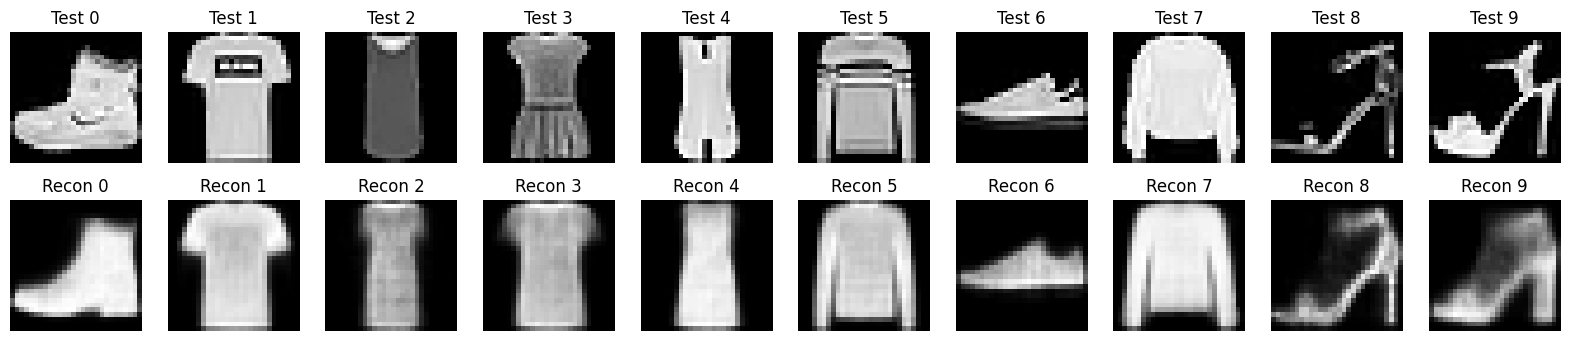

In [ ]:
#原图与重构图的对比
fig, axs = plt.subplots(2, 10, figsize=(20, 4))  # 2 行 10 列

for i in range(10):
    test_data = (train_data.data[i].view(-1, 28*28).type(torch.FloatTensor)/255).to(device)
    _, result = model(test_data)
    result = result.view(28, 28).detach().cpu().numpy()


    axs[0, i].imshow(train_data.data[i].cpu().numpy(), cmap='gray')
    axs[0, i].set_title('Test {}'.format(i))
    axs[0, i].axis('off')

    axs[1, i].imshow(result, cmap='gray')
    axs[1, i].set_title('Recon {}'.format(i))
    axs[1, i].axis('off')

plt.show()